<a href="https://colab.research.google.com/github/tortoisehare/TSR-GAN/blob/master/TSFClassifier_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modified by: Stephanie Tietz

Original Model from: muddassir235 on full German Traffic Sign dataset

https://github.com/muddassir235/German-Traffic-Sign-Classifier

Modified to work with German TS Dataset plus "not a sign" images, optimized for 3 classes first then expanding to 44

Multiclass Image Classification in TensorFlow

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os


In [0]:
#upload data
#from google.colab import files

#uploaded = files.upload()

#traindata = np.load('smalltrain.npy') #only 3 classes, both circle signs
#traindata = np.load('alltrain.npy') #all classes

#testdata = np.load('smalltest.npy')
#testdata = np.load('alltest.npy')

In [3]:
traindata = np.load('smalltrain2.npy') #smalltrain2 has triangle sign
testdata = np.load('smalltest2.npy')

print(traindata.shape) #expect (5620, 3073) for triangle dataset, (41109,3073) for all
print(testdata.shape) #expect (1900, 3073) for triangle dataset, (13330,3073) for all
print(testdata)

(5620, 3073)
(1900, 3073)
[[214 217 218 ... 134 136   2]
 [123 123 126 ...  51  47   2]
 [ 98  98  93 ...  99  94   2]
 ...
 [ 21  38  69 ...  37  27   1]
 [ 28  85  10 ...  50  21   0]
 [ 18  35  57 ...  19  29   1]]


In [4]:
from sklearn.utils import shuffle

#Randomize (shuffle) the data
traindata = shuffle(traindata, random_state=33)
testdata = shuffle(testdata, random_state=37)
print(testdata)

[[ 75  86 137 ...  50  54   2]
 [132  87  85 ...  25 197   1]
 [255 255 255 ... 255 255   2]
 ...
 [164 129  89 ... 116 125   2]
 [ 16 131 189 ... 117 153   1]
 [188 182 187 ... 129 130   2]]


In [5]:
#split into x and y
X_train = traindata[:,:-1]
Y_train = traindata[:,-1]
Y_train = Y_train.reshape(len(Y_train),1)
print(X_train.shape)
print(Y_train.shape)

X_test = testdata[:,:-1]
Y_test = testdata[:,-1]
Y_test = Y_test.reshape(len(Y_test),1)
print(X_test.shape)
print(Y_test.shape)

#reshape into (32,32,3) for each example for this model input
X_train = (X_train.reshape(traindata.shape[0], 3, 32, 32)).transpose([0,2,3,1])
print(X_train.shape)
X_test = (X_test.reshape(testdata.shape[0], 3, 32, 32)).transpose([0,2,3,1])
print(X_test.shape)

(5620, 3072)
(5620, 1)
(1900, 3072)
(1900, 1)
(5620, 32, 32, 3)
(1900, 32, 32, 3)


In [0]:
#Normalize data
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255

#compute mean image of training set and subtract from training images
chann_index_swap = np.swapaxes(X_train,0,3)
mean_image = [[[sum(pixel)/len(pixel) for pixel in col] for col in row] for row in chann_index_swap]
mean_image = np.swapaxes(mean_image,0,2)
mean_image = np.swapaxes(mean_image,0,1)

X_train = X_train - mean_image

In [0]:
num_classes = 3 #change to 44 for alldata

batch_size = 10

num_epochs = 15

assert(len(X_train)==len(Y_train))
n_train = len(X_train)
assert(len(X_test)==len(Y_test))
n_test = len(X_test)

image_size = 32
image_shape = (32, 32, 3)

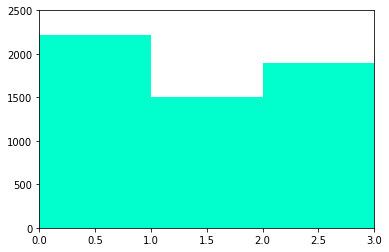

Class with most examples:
0 2220
Class with least examples:
1 1500


In [8]:
#Histogram visualization of classes
hist_data = np.histogram(Y_train, bins=range(num_classes+1))
hist_map = {}
for occr,i in zip(hist_data[0], hist_data[1]):
  hist_map[occr] = i

plt.hist(Y_train, bins=range(num_classes+1), color = '#00ffCC')
plt.axis([0,num_classes,0,2500])
plt.show()
print("Class with most examples:")
print(hist_map[np.amax(hist_data[0])],np.amax(hist_data[0]))
print("Class with least examples:")
print(hist_map[np.amin(hist_data[0])],np.amin(hist_data[0]))


In [0]:
'''Convenience Function'''
def conv2d(x,W,b,output_depth,train=1,strides=1):

    '''Tensor flow conv2d with same vertical and horizontal strides'''
    x = tf.nn.conv2d(x,W,strides=[1,strides,strides,1],padding='VALID')
    
    '''Batch Normaliztion'''
    x = batch_norm_conv(x,output_depth,train)
    
    '''Adding the bias'''
    x = tf.nn.bias_add(x,b)
    
    '''Relu Activation'''
    return tf.nn.relu(x)

In [0]:
'''Convenience Function'''
def max_pool(x,k=2):
    return tf.nn.max_pool(x,ksize=[1,k,k,1],strides=[1,k,k,1],padding='VALID')

In [0]:
#7 layers, 2 conv, 4 fully connected, plus output
depth = {
    '1_c': 30, #5x5
    '2_c': 200, #5x5
    '3_f': 2200,
    '4_f': 1000,
    '5_f': 500,
    '6_f': 120,
    '7_o': num_classes
}

In [12]:
#Weights Initialization using Xavier

weights = {
    '1_conv': tf.get_variable("W_1_conv", shape=[5, 5, 3, depth['1_c']],initializer=tf.contrib.layers.xavier_initializer()),
    
    '2_conv': tf.get_variable("W_2_conv", shape=[5, 5, depth['1_c'], depth['2_c']],initializer=tf.contrib.layers.xavier_initializer()),
    
    '3_fullc': tf.get_variable("W_3_fullc", shape=[5000, depth['3_f']],initializer=tf.contrib.layers.xavier_initializer()),
    
    '4_fullc': tf.get_variable("W_4_fullc", shape=[depth['3_f'], depth['4_f']],initializer=tf.contrib.layers.xavier_initializer()),
    
    '5_fullc': tf.get_variable("W_5_fullc", shape=[depth['4_f'], depth['5_f']],initializer=tf.contrib.layers.xavier_initializer()),
    
    '6_fullc': tf.get_variable("W_6_fullc", shape=[depth['5_f'], depth['6_f']],initializer=tf.contrib.layers.xavier_initializer()),
    
    '7_out': tf.get_variable("W_7_out", shape=[depth['6_f'], depth['7_o']],initializer=tf.contrib.layers.xavier_initializer())
}


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
'''Biases'''
biases = {
    '1_conv': tf.Variable(tf.zeros(depth['1_c'])),
    '2_conv': tf.Variable(tf.zeros(depth['2_c'])),
    '3_fullc': tf.Variable(tf.zeros(depth['3_f'])),
    '4_fullc': tf.Variable(tf.zeros(depth['4_f'])),
    '5_fullc': tf.Variable(tf.zeros(depth['5_f'])),
    '6_fullc': tf.Variable(tf.zeros(depth['6_f'])),
    '7_out': tf.Variable(tf.zeros(depth['7_o']))
}

In [0]:
def batch_norm_conv(x, n_out, train):
    """
    Batch normalization on convolutional maps.
    Ref.: http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope('bn'):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(train>0,mean_var_with_update,lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

In [0]:
def batch_norm_fullc(x, n_out, train):
    
    '''Batch normalization for fully connected layers'''
    
    with tf.variable_scope('bn'):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(train>0,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

In [0]:
from tensorflow import keras

def TS_Classifier(x,train=1):  
    
    ''' Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x30. '''
    conv1 = conv2d(x,weights['1_conv'],biases['1_conv'],depth['1_c'],train)

    # Max Pooling. Input = 28x28x30. Output = 14x14x30.
    conv1 = max_pool(conv1)
    
    
    ''' Layer 2: Convolutional. Input = 14x14x30 Output = 10x10x200. '''
    
    conv2 = conv2d(conv1,weights['2_conv'],biases['2_conv'],depth['2_c'],train)

    # Max Pooling. Input = 10x10x200. Output = 10x10x200.
    conv2 = max_pool(conv2)
    
    
    ''' Flatten: Input = 10x10x200. Output = 5000 '''
    
    fc0 = keras.layers.Flatten()(conv2)
    
    
    ''' Layer 3: Fully Connected. Input = 5000. Output = 2200. '''
    
    fullc1 = tf.add(tf.matmul(fc0,weights['3_fullc']),biases['3_fullc'])
    
    # Batch Normalization. (Only During Training)
    fullc1 = batch_norm_fullc(fullc1,depth['3_f'],train)
    
    # Relu Activation.
    fullc1 = tf.nn.relu(fullc1)
    
    # Dropout: 0.5 (Only During Training)
    fullc1 = tf.cond(train>0, lambda: tf.nn.dropout(fullc1,0.50), lambda: fullc1)
    
    
    ''' Layer 4: Fully Connected. Input = 2200. Output = 1000'''
    
    fullc2 = tf.add(tf.matmul(fullc1,weights['4_fullc']),biases['4_fullc'])
    
    # Batch Normalization (Only During Training)
    fullc2 = batch_norm_fullc(fullc2,depth['4_f'],train)
    
    # Relu Activation
    fullc2 = tf.nn.relu(fullc2)
    
    # Dropout: 0.5 (Only During Training)
    fullc2 = tf.cond(train>0, lambda: tf.nn.dropout(fullc2,0.50), lambda: fullc2)
    
    
    ''' Layer 5: Fully Connected. Input = 1000. Output = 500'''
    
    fullc3 = tf.add(tf.matmul(fullc2,weights['5_fullc']),biases['5_fullc'])
    
    # Batch normalization. (Only During Training)
    fullc3 = batch_norm_fullc(fullc3,depth['5_f'],train)
    
        # Relu Activation
    fullc3 = tf.nn.relu(fullc3)
    
    # Dropout: 0.5 (Only During Training)
    fullc3 = tf.cond(train>0, lambda: tf.nn.dropout(fullc3,0.50), lambda: fullc3)
    
    
    ''' Layer 6: Fully Connected. Input = 500. Output = 120'''
    
    fullc4 = tf.add(tf.matmul(fullc3,weights['6_fullc']),biases['6_fullc'])
    
    # Batch normalization. (Only During Training)
    fullc4 = batch_norm_fullc(fullc4,depth['6_f'],train)
    
    # Relu Activation
    fullc4 = tf.nn.relu(fullc4)
    
    # Dropout 0.5 (Only During Training)
    fullc4 = tf.cond(train>0, lambda: tf.nn.dropout(fullc4,0.50), lambda: fullc4)
    
    
    ''' Layer 7: Output, Fully Connected. Input = 120. Output = num_classes'''
    
    logits = tf.add(tf.matmul(fullc4,weights['7_out']),biases['7_out'])
    #print(logits.get_shape())
    return logits

In [55]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

one_hot_y = tf.one_hot(y,3)
#print(one_hot_y.get_shape())



'''Learning rate made into a placeholder for exponential decay'''
rate = tf.placeholder(tf.float32)

'''L2 Regularization Hyper-parameter'''
beta = tf.placeholder(tf.float32)

'''Parameter for switching between training and testing modes'''
train = tf.placeholder(tf.int32)

'''Initial Learning Rate'''
lr = 0.0001

'''L2 regularization (Beta)'''
b = 1e-6

'''Rate of Learning rate decay'''
k = 1e-7


'''MODEL'''
logits = TS_Classifier(x,train)

'''LOSS'''
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss = tf.reduce_mean(cross_entropy)
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['1_conv']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['2_conv']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['3_fullc']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['4_fullc']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['5_fullc']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['6_fullc']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['7_out']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['1_conv']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['2_conv']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['3_fullc']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['4_fullc']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['5_fullc']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['6_fullc']))
loss_operation = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['7_out']))

'''OPTIMIZER'''
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Tensor("Add_156:0", shape=(?, 3), dtype=float32)


In [0]:
correct_prediction = tf.equal(tf.argmax(logits, axis=0), tf.argmax(one_hot_y, axis=0))

accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    #print("in evaluate")
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]

        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,train:-1})
        #print("after accuracy")
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [19]:
import math

''' Small Training Subset of 20 images '''
small_sample_x = X_train[0:20]
small_sample_y = Y_train[0:20]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer(),feed_dict={train:1})
    num_examples = len(small_sample_x)
    
    batch_size = 10
    print("Can we overfit?.......")
    print()
    
    print("Decay: "+str(k))
    for i in range(100):
        
        lr = float(lr*np.exp(-k*i))
        
        for offset in range(0,num_examples,batch_size):
            end = offset + batch_size
            batch_x, batch_y = small_sample_x[offset:end], Y_train[offset:end]
            sess.run(training_operation, feed_dict={x:small_sample_x, y:small_sample_y, train:-1, rate:lr, beta:b})
            
        c = sess.run(loss_operation, feed_dict={x: small_sample_x, y: small_sample_y,train:-1, rate:lr, beta:b})
        print("Epoch: "+str(i)+" loss: "+str(c)+" learn rate:"+str(lr)+" beta: "+str(b)+" decay: "+str(k))

Can we overfit?.......

Decay: 1e-07
Epoch: 0 loss: 51065440.0 learn rate:0.0001 beta: 1e-06 decay: 1e-07
Epoch: 1 loss: 0.0026751799 learn rate:9.99999900000005e-05 beta: 1e-06 decay: 1e-07
Epoch: 2 loss: 847262.4 learn rate:9.99999700000045e-05 beta: 1e-06 decay: 1e-07
Epoch: 3 loss: 0.0026724054 learn rate:9.9999940000018e-05 beta: 1e-06 decay: 1e-07
Epoch: 4 loss: 0.0026707884 learn rate:9.999990000005e-05 beta: 1e-06 decay: 1e-07
Epoch: 5 loss: 148232.8 learn rate:9.999985000011251e-05 beta: 1e-06 decay: 1e-07
Epoch: 6 loss: 0.0026671884 learn rate:9.99997900002205e-05 beta: 1e-06 decay: 1e-07
Epoch: 7 loss: 47243.6 learn rate:9.999972000039199e-05 beta: 1e-06 decay: 1e-07
Epoch: 8 loss: 0.0026633039 learn rate:9.9999640000648e-05 beta: 1e-06 decay: 1e-07
Epoch: 9 loss: 0.0026612824 learn rate:9.99995500010125e-05 beta: 1e-06 decay: 1e-07
Epoch: 10 loss: 0.002659195 learn rate:9.99994500015125e-05 beta: 1e-06 decay: 1e-07
Epoch: 11 loss: 0.0026570498 learn rate:9.9999340002178e-05

In [0]:
EPOCHS = 100
BATCH_SIZE = 10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer(), feed_dict={train:1})
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        lr = float(lr*np.exp(-k*i))
        
        #X_train, Y_train = shuffle(X_train, Y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
            #print(batch_x.shape)
            #print(batch_y.shape)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, train:1, rate:lr, beta:b})
        
        #print(X_test.shape)
        #print(Y_test.shape)
        
        test_accuracy = evaluate(X_test, Y_test)
        print("EPOCH {} ...".format(i+1))
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        print()
        
    saver.save(sess, 'ts_classifier')
    print("Model saved")

Training...

in evaluate
EPOCH 1 ...
Test Accuracy = 0.195

in evaluate
EPOCH 2 ...
Test Accuracy = 0.209

in evaluate
EPOCH 3 ...
Test Accuracy = 0.214

in evaluate
EPOCH 4 ...
Test Accuracy = 0.219

